# [Title Here - last thing to update]

### INTRODUCTION [copy from report - no one needs to spend time on this]

- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question

### METHODS & RESULTS

- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis. (AJ Dreher)
- your report should include code which: (Charul)
 - loads data from the original source on the web **(not from /data folder)**
 - wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
 - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
 - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
 - performs the data analysis
 - creates a visualization of the analysis 


*note: all tables and figure should have a figure/table number and a legend*

In [64]:
library(tidyverse)
library(repr)
library(caret)
library(ggplot2)
library(tidymodels)
library (forcats)

In [65]:
# collect data directly from web instead

student_data <- read_delim("data/student-por.csv", delim = ";")

glimpse (student_data)

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



Rows: 649
Columns: 33
$ school     <chr> "GP", "GP", "GP", "GP", "GP", "GP", "GP", "GP", "GP", "GP"…
$ sex        <chr> "F", "F", "F", "F", "F", "M", "M", "F", "M", "M", "F", "F"…
$ age        <dbl> 18, 17, 15, 15, 16, 16, 16, 17, 15, 15, 15, 15, 15, 15, 15…
$ address    <chr> "U", "U", "U", "U", "U", "U", "U", "U", "U", "U", "U", "U"…
$ famsize    <chr> "GT3", "GT3", "LE3", "GT3", "GT3", "LE3", "LE3", "GT3", "L…
$ Pstatus    <chr> "A", "T", "T", "T", "T", "T", "T", "A", "A", "T", "T", "T"…
$ Medu       <dbl> 4, 1, 1, 4, 3, 4, 2, 4, 3, 3, 4, 2, 4, 4, 2, 4, 4, 3, 3, 4…
$ Fedu       <dbl> 4, 1, 1, 2, 3, 3, 2, 4, 2, 4, 4, 1, 4, 3, 2, 4, 4, 3, 2, 3…
$ Mjob       <chr> "at_home", "at_home", "at_home", "health", "other", "servi…
$ Fjob       <chr> "teacher", "other", "other", "services", "other", "other",…
$ reason     <chr> "course", "course", "other", "home", "home", "reputation",…
$ guardian   <chr> "mother", "father", "mother", "mother", "father", "mother"…
$ traveltime <dbl> 2, 1, 1, 1,

In [66]:
student_data <- student_data %>% 
                mutate (parent_ed = (Medu + Fedu)/2) %>% 
            select (G3, absences, parent_ed, studytime)

student_data %>% head (10)

G3,absences,parent_ed,studytime
<dbl>,<dbl>,<dbl>,<dbl>
11,4,4.0,2
11,2,1.0,2
12,6,1.0,2
14,0,3.0,3
13,0,3.0,2
13,6,3.5,2
13,0,2.0,2
13,2,4.0,2
17,0,2.5,2


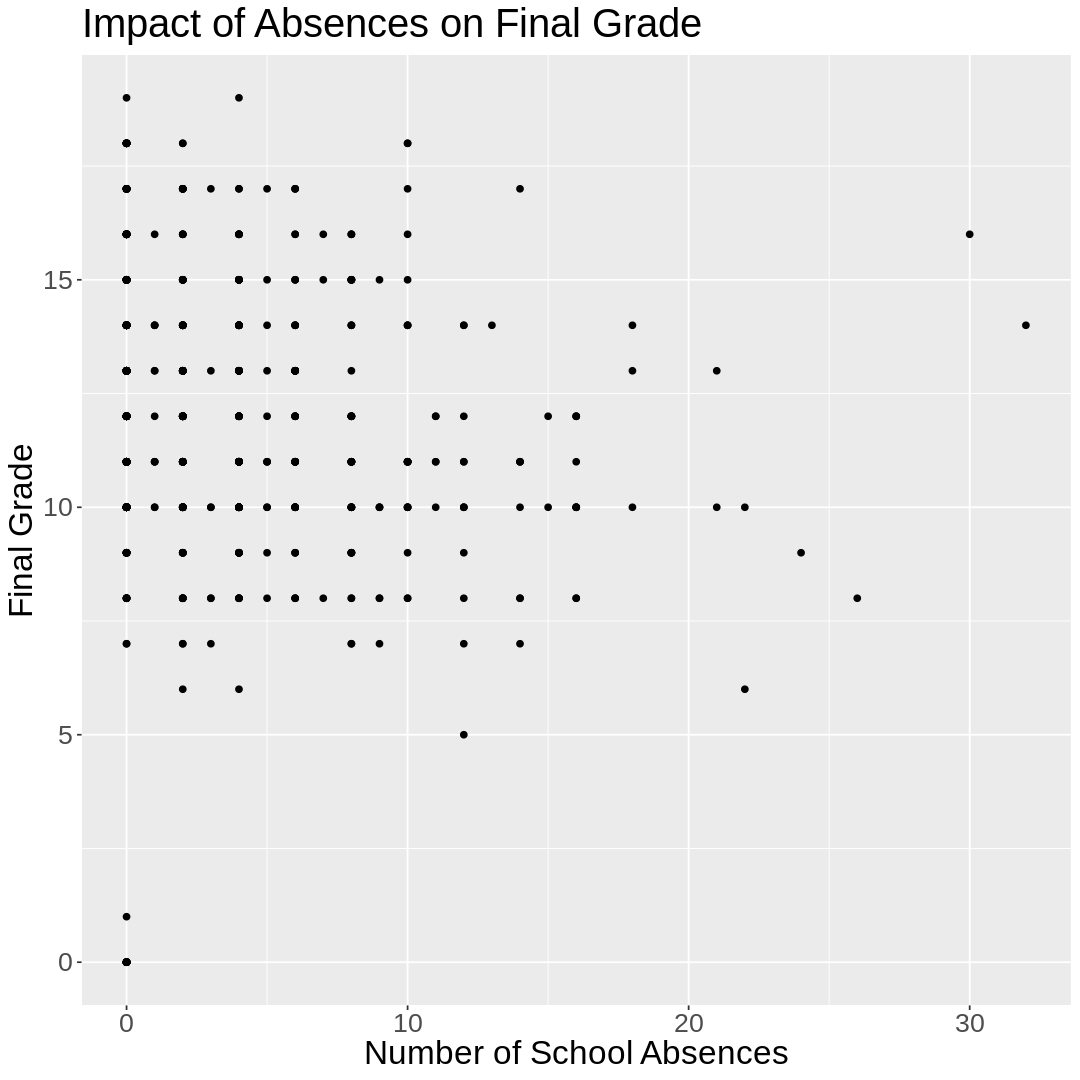

In [67]:
options(repr.plot.width = 9, repr.plot.height = 9)

absences_plot <- ggplot(student_data, aes(x = absences, y = G3)) + 
  geom_point() + 
  xlab("Number of School Absences") +
  ylab("Final Grade") + 
    labs (title = "Impact of Absences on Final Grade") +
theme(text = element_text(size=20)) 

absences_plot

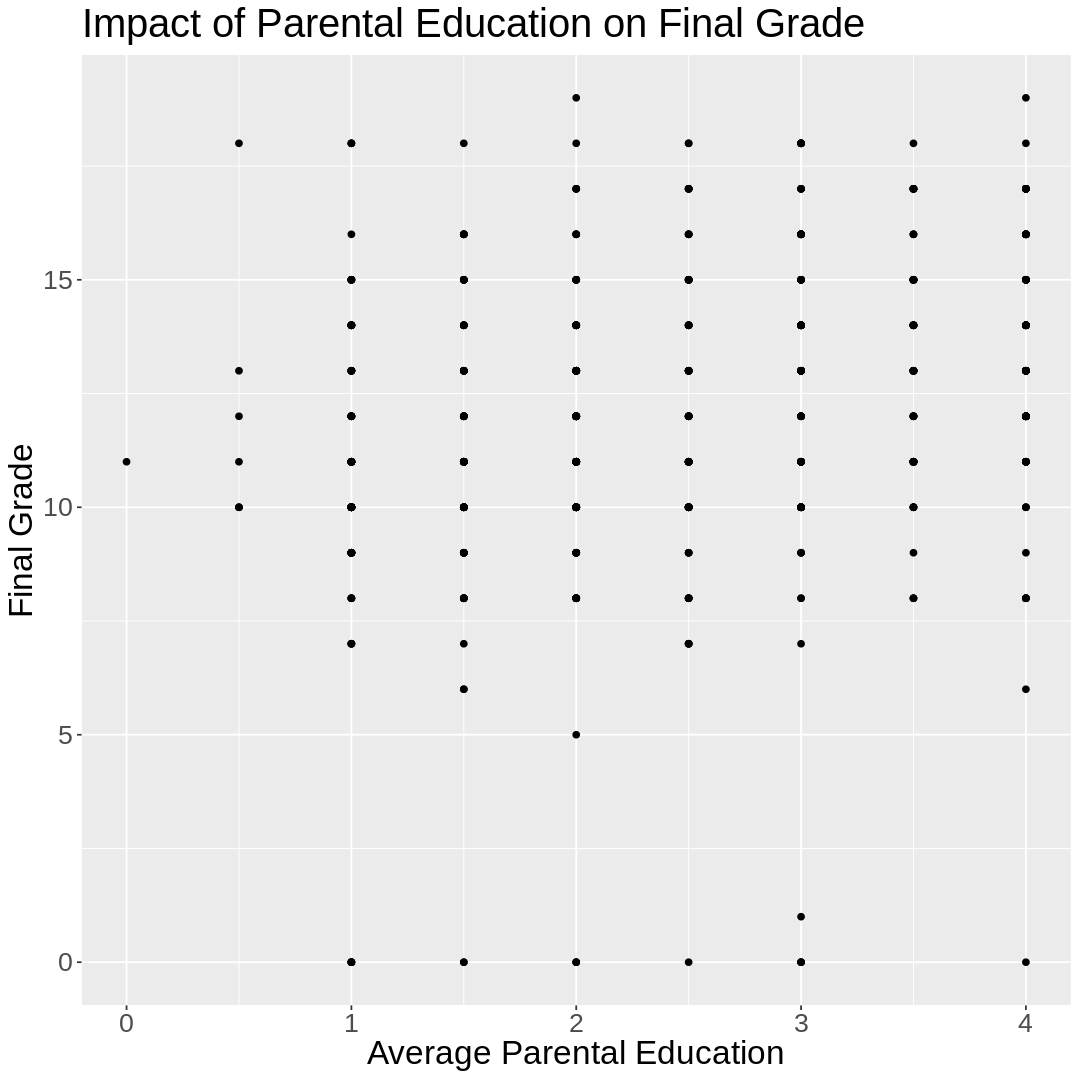

In [68]:
parent_ed_plot <- ggplot(student_data, aes(x = parent_ed, y = G3)) + 
  geom_point() + 
  xlab("Average Parental Education") +
  ylab("Final Grade") + 
    labs (title = "Impact of Parental Education on Final Grade") +
theme(text = element_text(size=20)) 

parent_ed_plot

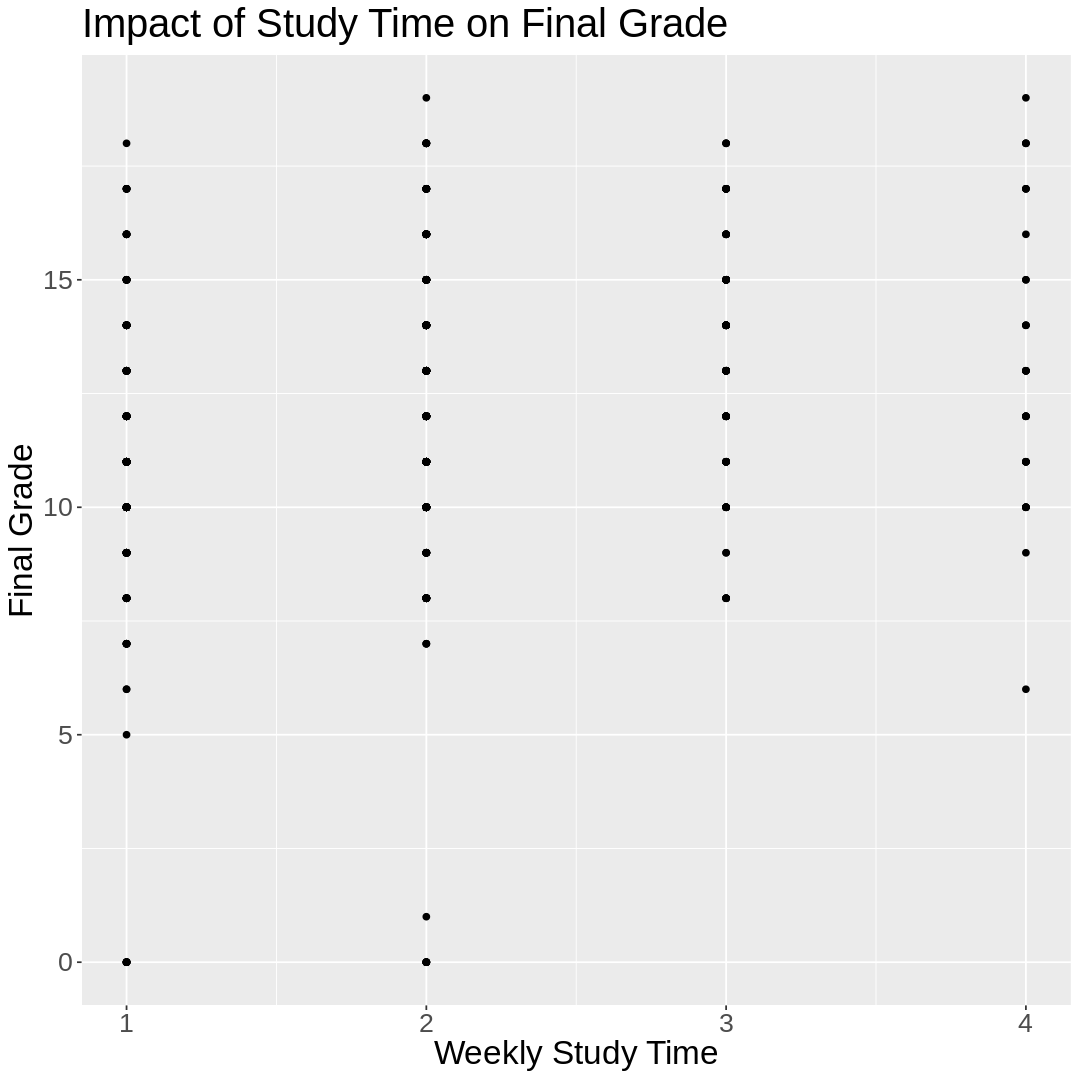

In [69]:
studytime_plot <- ggplot(student_data, aes(x = studytime, y = G3)) + 
  geom_point() + 
  xlab("Weekly Study Time") +
  ylab("Final Grade") + 
    labs (title = "Impact of Study Time on Final Grade") +
theme(text = element_text(size=20)) 

studytime_plot

In [70]:
set.seed (1)

#k-nn regression with first predictor, absences

student_split <- initial_split(student_data, prop = 0.7, strata = G3)
student_train <- training(student_split)
student_test <- testing(student_split)

student_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("regression")

absences_recipe <- recipe(G3 ~ absences, data = student_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

student_vfold <- vfold_cv(student_train, v = 5, strata = G3)

absences_wkflw <- workflow() %>%
  add_recipe(absences_recipe) %>%
  add_model(student_spec)

In [71]:
gridvals <- tibble(neighbors = seq(1, 200))

absences_results <- absences_wkflw %>%
  tune_grid(resamples = student_vfold, grid = gridvals) %>%
  collect_metrics()

absences_min <- absences_results %>%
  filter(.metric == "rmse") %>%
  filter(mean == min(mean))
absences_min

#this indicates k with the lowest rmse on the basis of cross-validation and tuning

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
29,rmse,standard,3.227304,5,0.245183,Model029


In [72]:
absences_kmin <- absences_min %>% pull(neighbors)

absences_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) %>%
  set_engine("kknn") %>%
  set_mode("regression")

absences_fit <- workflow() %>%
  add_recipe(absences_recipe) %>%
  add_model(absences_spec) %>%
  fit(data = student_train)

absences_summary <- absences_fit %>%
  predict(student_test) %>%
  bind_cols(student_test) %>%
  metrics(truth = G3, estimate = .pred)
absences_summary

# rmspe with testing data, with chosen k

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.2083063712
rsq,standard,0.0001744528
mae,standard,2.3391304348


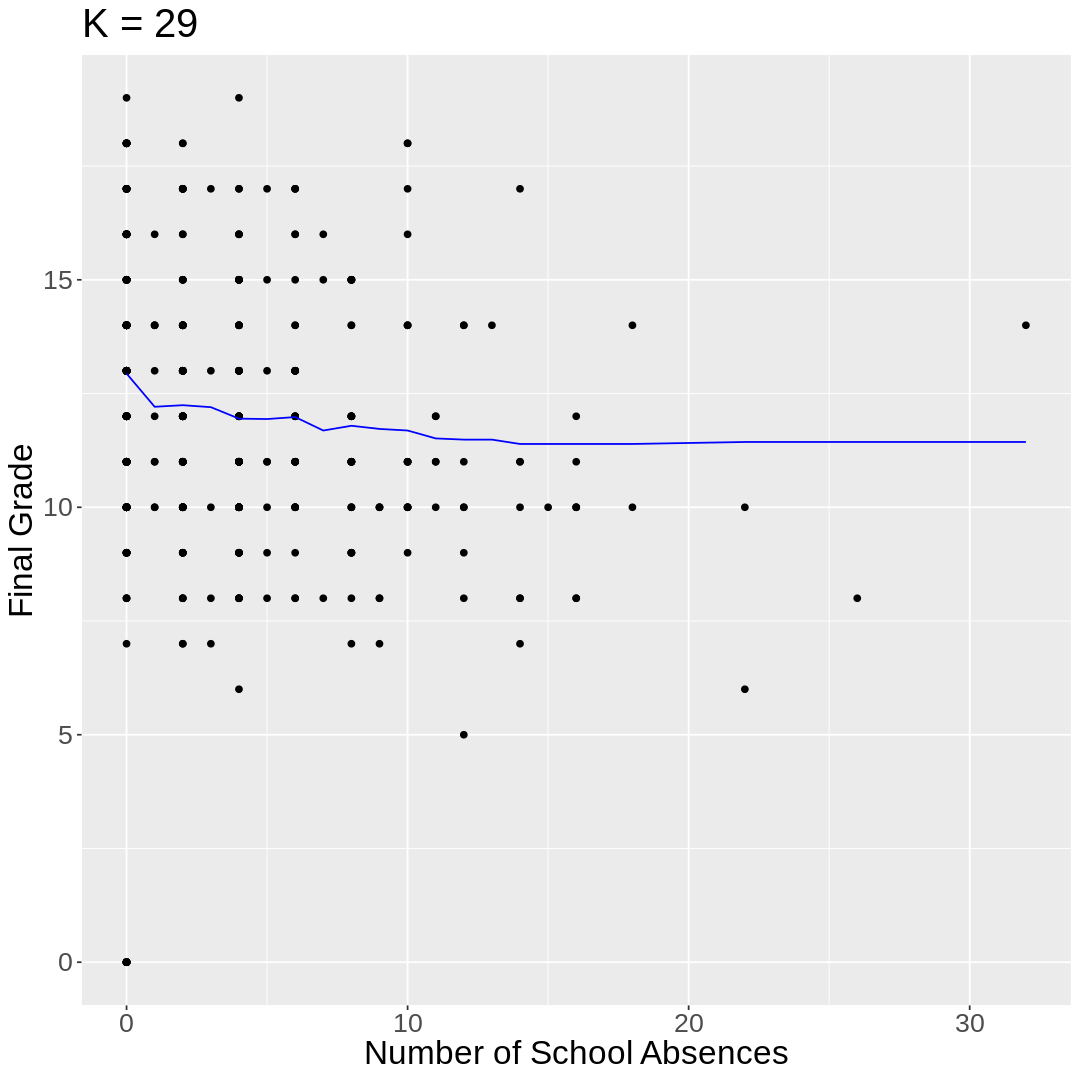

In [73]:
absences_preds <- absences_fit %>%
  predict(student_train) %>%
  bind_cols(student_train)

absences_plot <- ggplot(absences_preds, aes(x = absences, y = G3)) +
  geom_point() +
  xlab("Number of School Absences") +
  ylab("Final Grade") +
  geom_line(data = absences_preds, aes(x = absences, y = .pred), color = "blue") +
  ggtitle(paste0("K = ", absences_kmin)) +
theme(text = element_text(size=20)) 

absences_plot

# scatterplot with k-nn regression line

In [74]:
# repeat of k-nn regression analysis with second predictor, parental education level

parent_ed_recipe <- recipe(G3 ~ parent_ed, data = student_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

parent_ed_wkflw <- workflow() %>%
  add_recipe(parent_ed_recipe) %>%
  add_model(student_spec)

In [75]:
gridvals <- tibble(neighbors = seq(1, 200))

parent_ed_results <- parent_ed_wkflw %>%
  tune_grid(resamples = student_vfold, grid = gridvals) %>%
  collect_metrics()

parent_ed_min <- parent_ed_results %>%
  filter(.metric == "rmse") %>%
  filter(mean == min(mean))
parent_ed_min


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
115,rmse,standard,3.155908,5,0.212894,Model115


In [76]:
parent_ed_kmin <- parent_ed_min %>% pull(neighbors)

parent_ed_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = parent_ed_kmin) %>%
  set_engine("kknn") %>%
  set_mode("regression")

parent_ed_fit <- workflow() %>%
  add_recipe(parent_ed_recipe) %>%
  add_model(parent_ed_spec) %>%
  fit(data = student_train)

parent_ed_summary <- parent_ed_fit %>%
  predict(student_test) %>%
  bind_cols(student_test) %>%
  metrics(truth = G3, estimate = .pred)
parent_ed_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.02364231
rsq,standard,0.06762678
mae,standard,2.21937373


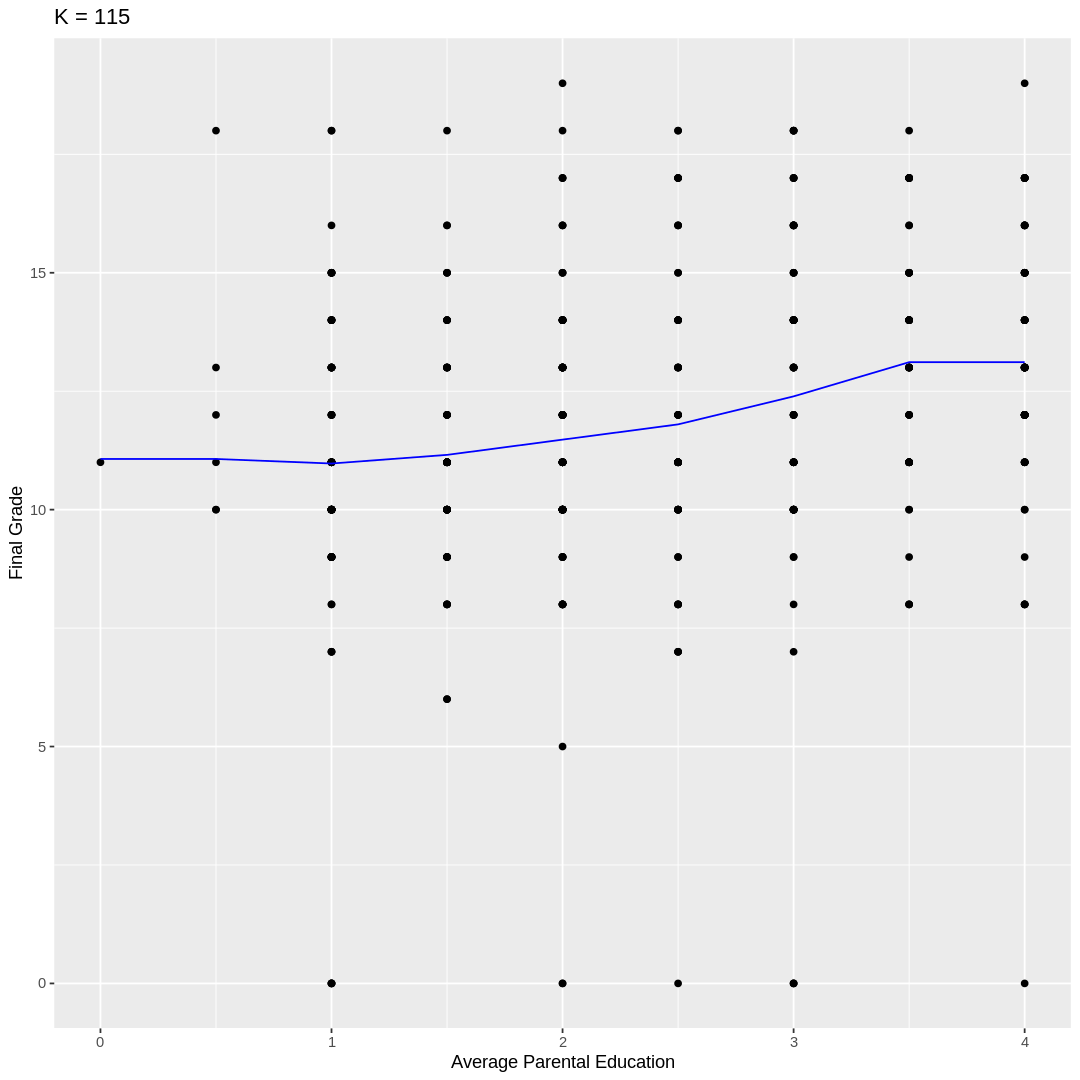

In [77]:
parent_ed_preds <- parent_ed_fit %>%
  predict(student_train) %>%
  bind_cols(student_train)

parent_ed_plot <- ggplot(parent_ed_preds, aes(x = parent_ed, y = G3)) +
  geom_point() +
  xlab("Average Parental Education") +
  ylab("Final Grade") +
  geom_line(data = parent_ed_preds, aes(x = parent_ed, y = .pred), color = "blue") +
  ggtitle(paste0("K = ", parent_ed_kmin))
parent_ed_plot

In [78]:
# k-nn analysis to be done with third predictor, studytime

## Discussion (Avery)
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

### References
- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references)
- Make sure to cite the source of your data as well

**Potential sources:**
- https://inservice.ascd.org/exploring-learning-and-health-what-influences-a-childs-ability-to-learn/
- https://www.education.vic.gov.au/school/teachers/teachingresources/Pages/identifying-high-ability-students.aspx
- https://www.oecd.org/site/educeri21st/40600533.pdf (good source)
- https://owlcation.com/academia/Factors-that-affect-Student-Learning